In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
#sns.set_context('paper')
#from matplotlib_visuals import *

import asg

%matplotlib inline

IP = '192.168.1.117'
maxf = 7629



In [4]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 600

In [233]:
def sloping_pulse(start, slope_length, pulse_width, size=2**14):
    #     # Entries now in ns!!
    """By default the there are three samples with value zero at the start of the pulse.
    Otherwise the DC signal starts going mayhem after. This means the earliest possible
    pulse always has a start time of 24 ns"""

    start = round(start / 8) + 2                         # one sample from linspace
    slope_length = 2 + round(slope_length / 8)           # linspace of length 2 is just [0, 1] --> no slope
    pulse_width = round(pulse_width / 8) - 2
    
    amplitude = 1
    if size is None:
        size = start + 2 * slope_length + pulse_width + 3

    # total_pulse_length = start + 2 * slope_length + pulse_width + 3
    pulse = np.zeros(size)
    slope = np.linspace(0, amplitude, slope_length)
    pulse[start: start + slope_length] = slope
    pulse[start + slope_length + pulse_width: pulse_width + start + 2 * slope_length] = np.flip(slope, axis=0)

    pulse[start + slope_length: start + slope_length + pulse_width] = amplitude

    return pulse

[0.         0.         0.         0.16666667 0.33333333 0.5
 0.66666667 0.83333333 1.         0.83333333 0.66666667 0.5
 0.33333333 0.16666667 0.         0.         0.         0.
 0.         0.        ]


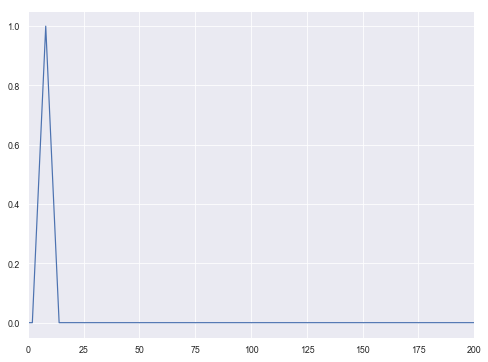

In [236]:
pulse = sloping_pulse(start=0, slope_length=40, pulse_width=8)
plt.plot(pulse)
plt.xlim(left=0, right=200)
print(pulse[0:20])

In [128]:
rp = asg.start(IP)

asg.reset(rp=rp)
asg.setup(rp=rp, output=1, waveform='arbitrary', data=pulse, frequency=maxf, amplitude=1, burst_mode=True, bursts=1)


In [130]:
asg.on(rp=rp, output=1)

In [85]:
asg.trigger(rp=rp, output=1)

In [92]:
asg.off(rp=rp)

In [6]:
def csv_to_array(filename, channels=2):
    from pandas import read_csv
    df = read_csv(filename)
    array = df.to_numpy()
    if channels == 1:
        ch1 = np.fromiter(array[1:,1], float)
        increment = array[0,3]
        t = np.fromiter(array[1:,0], float)*increment
        return ch1, t
    elif channels == 2:
        ch2 = np.fromiter(array[1:,2], float)
        increment = array[0,4]
        t = np.fromiter(array[1:,0], float)*increment
        return ch1, ch2, t 
    
    

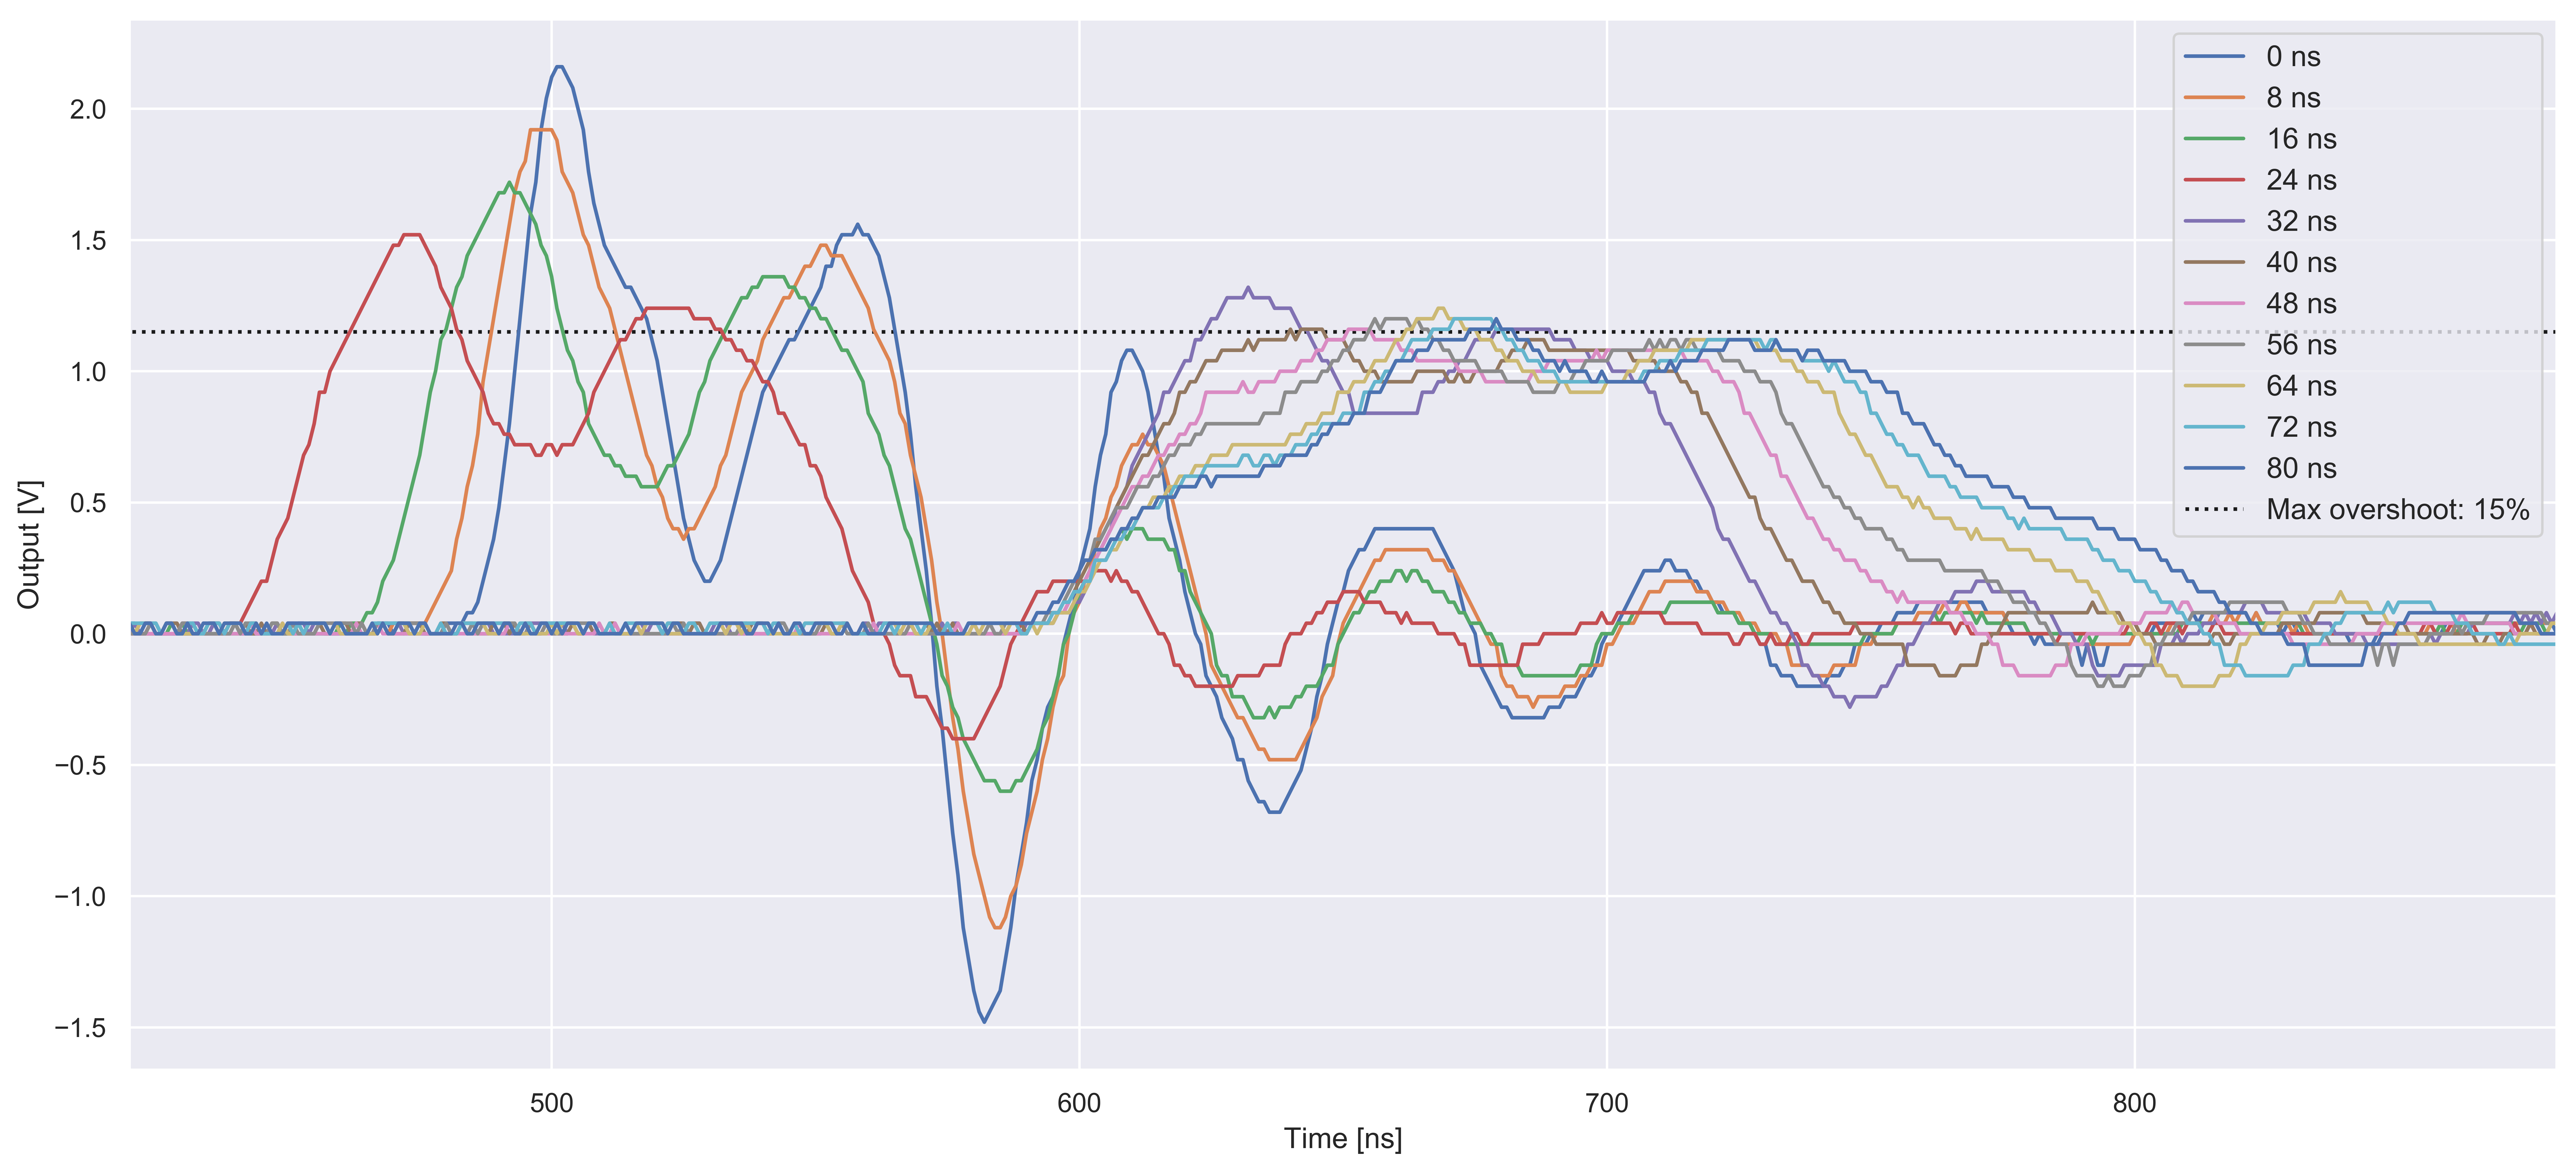

In [20]:
plt.figure(figsize=(18,8))

for i in range(0,11):
    filename = 'scope_data/slope_test/short/' + str(i*8) + 'ns.csv'
    ch1, t = csv_to_array(filename, channels=1)
    plt.plot(t*1e9, ch1, label=str(i*8)+' ns')

plt.hlines(1.15, 0, 1.2*1e3, linestyles='dotted', label='Max overshoot: 15%')
plt.xlim(left=420, right=880)
plt.legend(frameon=True, loc='upper right', prop={'size': 12})
plt.xlabel('Time [ns]')
plt.ylabel('Output [V]')
#plt.xlim(left=575)
#plt.title('Short pulse fall time comparison')
plt.savefig('600dpi_images/short_pulse_rise_time_comparison_v2.eps', format='eps')

Text(0.5, 1.0, 'Long pulse fall time comparison')

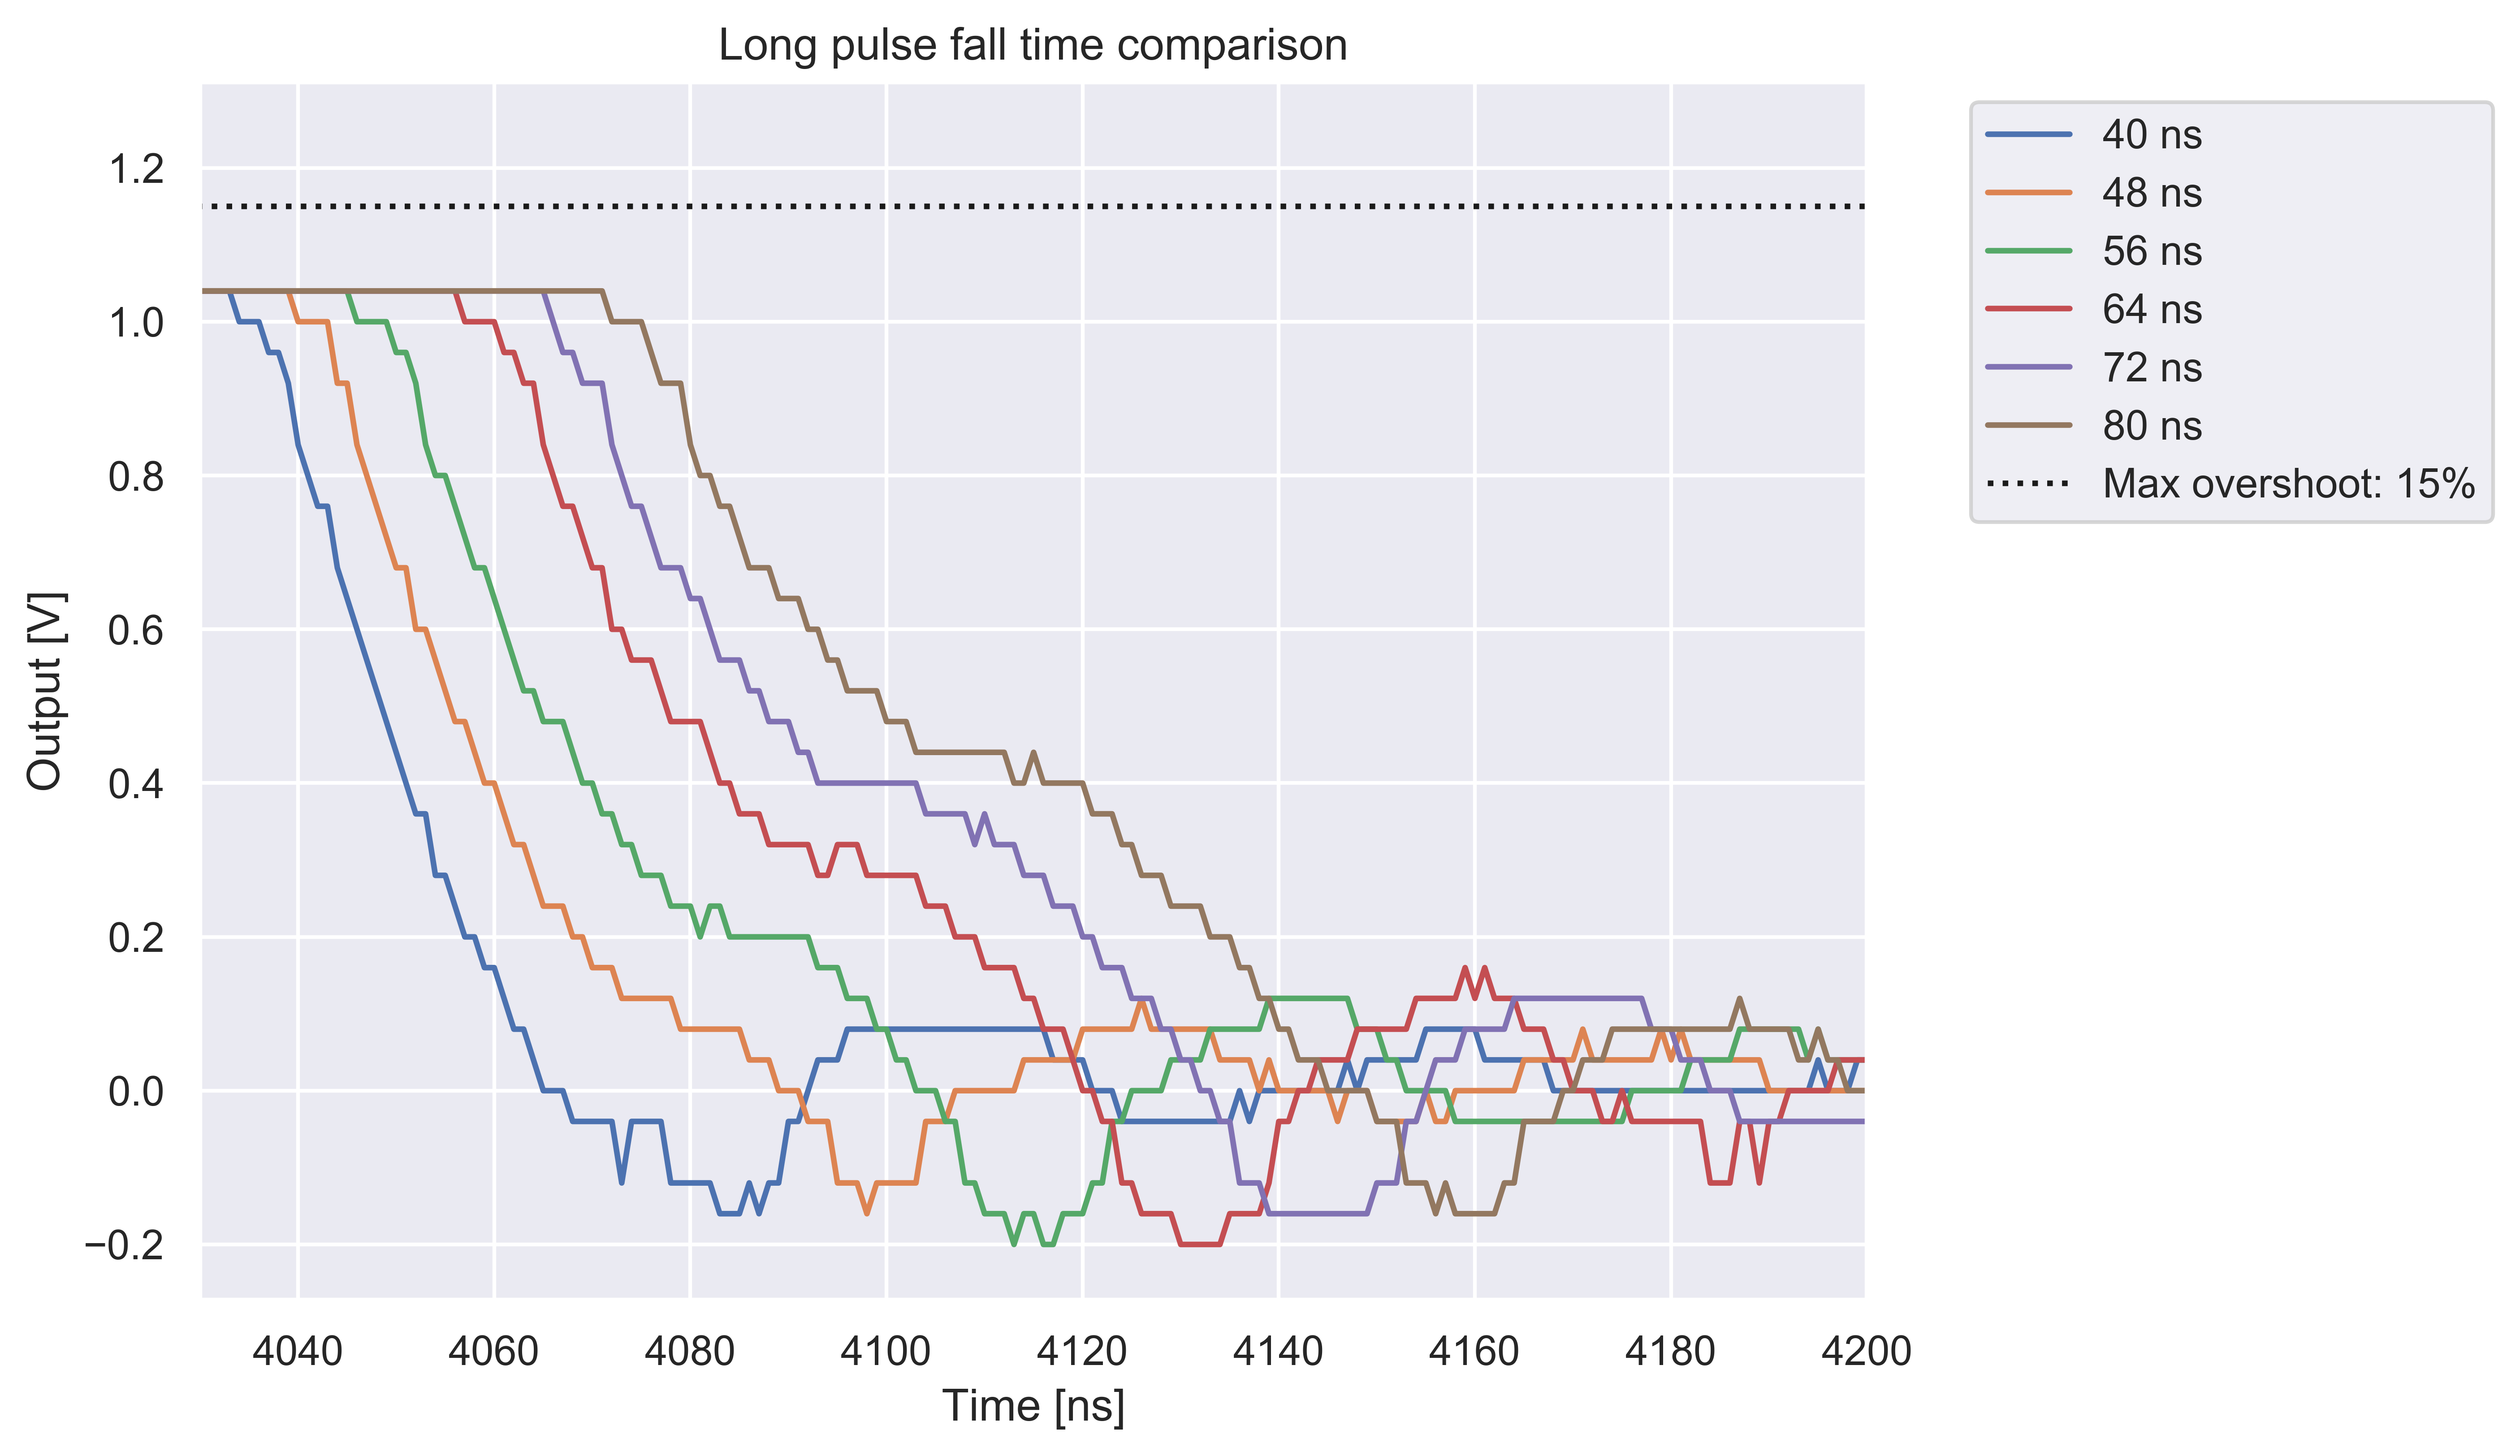

In [8]:
for i in range(5,11):
    filename = 'scope_data/slope_test/long/' + str(i*8) + 'ns.csv'
    ch1, t = csv_to_array(filename, channels=1)
    plt.plot(t*1e9, ch1, label=str(i*8)+' ns')

plt.hlines(1.15, 0, 6000, linestyles='dotted', label='Max overshoot: 15%')
plt.legend()
plt.xlim(left=4030, right=4200)
plt.legend(frameon=True, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Time [ns]')
plt.ylabel('Output [V]')
plt.title('Long pulse fall time comparison')

# Conclusion: 5 sample/40 ns slope seems to be good enough and actually behaves better in some cases than longer rise times!